# Brock-Mirman Surrogate Analysis
by Hanno Kase, Matthias Rottner, and Fabio Stohler

This notebook provides an end-to-end walkthrough of the analytical Brock-Mirman model and the surrogate-learning pipeline from *Generative Economic Modeling* (BIS Working Paper 1312).

Paper: https://www.bis.org/publ/work1312.htm  
Docs: https://fabio-stohler.github.io/Generative-Economic-Modeling/  
Code: https://github.com/Fabio-Stohler/Generative-Economic-Modeling

Note that we have changed some settings, e.g., the number of iterations, to ensure that the code runs fast in most environments.

---------------------------------------------------------------------------

The model is a **three-equation Real-Business-Cycle model** which we can solve analytically. For the details consult the above paper. The model features three shocks to Total Factor Productivity (TFP) $A_t$, to labor-augmenting productivity $Z_t$, as well as to the markup $\mu_t$. Based on the assumptions of Brock-Mirman, we can solve the model analytically. The following three equations describe the solution of the model:

\begin{align}
C_t &= \left( 1 - \frac{\alpha \beta}{\mu} \right) Y_t, \\
K_{t+1} &= \frac{\alpha \beta}{\mu} Y_t, \\
N_t &= \left[ \frac{\mu (1 - \tau^L) (1 - \alpha)}{\mu_t \omega (1 + \tau^C)(\mu - \alpha \beta)} \right]
\end{align}

Below, we use this analytical solution of the model to simulate different versions of the model with one or two shocks active at the same time. We then simulate data from these solved models and train a neural network, a so-called surrogate on them, to approximate the true solution outlined by the three equations above. Thereafter, we evaluate how well we are able to approximate the true solution with our methodology.

## Configuration
Set the switches below to control whether you regenerate data and retrain models. If a switch is `False`, cached artifacts in `bld/` are reused.

- `COLAB_SETUP`: set `True` to clone/install the repo in Colab.
- `Force_CPU`: force CPU usage even if CUDA is available.
- `retrain`: train surrogates from scratch.
- `rerun`: regenerate simulation datasets.
- `truncate_length`: cap dataset length for faster runs.

*Note that retraining and data regeneration can take up to an hour depending on hardware.*


### Google Colab notebook setup


*Note that it can take a while to install the generative-economic-modeling package.*

In [1]:
from pathlib import Path
import sys
import os

COLAB_SETUP = True  # set True in Colab to clone & install this repo
if COLAB_SETUP:
    REPO_URL = "https://github.com/Fabio-Stohler/Generative-Economic-Modeling.git"
    BRANCH = "main"
    CLONE_DIR = Path("/content/generative-economic-modeling")

    if not CLONE_DIR.exists():
        !git clone --depth 1 --branch $BRANCH $REPO_URL $CLONE_DIR
    %cd $CLONE_DIR
    %pip install -q numpy pandas scipy torch matplotlib tqdm
    %pip install -q -e . --no-deps
    BASE_DIR = CLONE_DIR
else:
    try:
        BASE_DIR = Path(__file__).resolve().parent.parent
    except NameError:
        cwd = Path.cwd()
        BASE_DIR = cwd.parent if cwd.name == "examples" else cwd

# Ensure source is importable without installing the package
sys.path.insert(0, str(BASE_DIR / "src"))

DATA_DIR = BASE_DIR / "bld" / "data" / "BM"
FIG_DIR = BASE_DIR / "bld" / "figures" / "BM"
NN_DIR = BASE_DIR / "bld" / "models" / "BM"

c:\content\generative-economic-modeling
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Load packages


In [2]:
# Third-party dependencies
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from tqdm import trange

# Local imports
from gem import plots
from gem.data import (
    ar1_lognormal_draws,
    calculate_EEE_BM,
    calculate_EEE_BM_Ana,
    construct_single_xy,
    simulate_and_save,
    simulate_BM,
    standardized_moments,
    tensor_to_dataframe,
    load_dataset,
)
from gem.surrogates import Surrogate

### Device selection
If a GPU is available, PyTorch will use it unless `Force_CPU = True`.


In [3]:
Force_CPU = True

device = "cuda" if torch.cuda.is_available() else "cpu"
if Force_CPU:
    device = "cpu"
    print("Forcing CPU usage.")

Forcing CPU usage.


## Brock-Mirman Surrogate Pipeline
Outline:
1. **Run-time switches** - configure regeneration and training.
2. **Reproducibility & plotting** - seeds and matplotlib defaults.
3. **Data generation settings** - parameters and shock distributions.
4. **Data generation / loading** - simulate or load datasets.
5. **Preprocessing** - flatten, construct (x, y), and combine datasets.
6. **Surrogates** - specify architecture and train/load models.
7. **Evaluation & plots** - loss curves and error histograms.
8. **Euler errors** - static and dynamic diagnostics.
9. **Moments** - simulate forward and report standardized moments.


## Run-time switches
- `retrain`: train surrogates (True) or load cached ones (False).
- `rerun`: regenerate simulation datasets (True) or load cached pickles (False).
- `truncate_length`: cap dataset length for faster experiments.

*Note that training and simulation can take time on CPU; consider reducing `truncate_length` for quick tests.*


In [4]:
retrain = False
rerun = False

# Truncation length for dataset
truncate_length = 10000  # Set to None to use the full dataset

## Reproducibility and plotting defaults
We fix random seeds for deterministic runs and set basic matplotlib defaults for readability.


In [5]:
# Fix seed for torch and numpy
torch.manual_seed(42)
np.random.seed(42)

In [6]:
# Increase the font size
plt.rcParams.update({"font.size": 13})

## Data generation settings


*Note that this section defines the structural parameters and shock distributions used to simulate the Brock-Mirman economy. The distributions correspond to partial-information variants used later for surrogate training.*


### Parameters and shock distributions
Define baseline structural parameters and the shock distributions for full and partial-information variants.


In [7]:
# simulate data
# Settings for the experiment in general
experiment_settings = {
    "draws": 1,
    "steps": 10001,
    "burn": 0,
    "labnorm": True,
    "normalize_input": True,
    "scale_output": False,
    "model_save_path": str(DATA_DIR) + "/",
    "fig_save_path": str(FIG_DIR) + "/",
    "nn_save_path": str(NN_DIR) + "/",
}

# Specify the parameters, ranges and distributions for the experiment
# Parameters
par = {
    "alpha": 0.33,
    "beta": 0.96,
    "omega": 1.0,
    "gamma": 5.0,
    "rho_a": 0.9,
    "rho_z": 0.9,
    "rho_mu": 0.0,
    "sigma_a": 0.05,
    "sigma_z": 0.05,
    "sigma_mu": 0.05,
    "Abar": 1.0,
    "Zbar": 1.0,
    "mubar": 1.0,
    "tau_L": 0.0,
    "tau_K": 0.0,
    "tau_C": 0.0,
    "kss": 1.0,
    "tau_switch": 0.0,
}

# distr_ranges for the simulation of different submodels
# Distributions of shocks for the simulation
distr_F = {
    "epsilon_a": torch.distributions.Normal(0.0, 1.0),
    "epsilon_z": torch.distributions.Normal(0.0, 1.0),
    "epsilon_mu": torch.distributions.Normal(0.0, 1.0),
    "tau": torch.distributions.Uniform(0.0, 1.0),
}
distr_AB = {
    "epsilon_a": torch.distributions.Normal(0.0, 1.0),
    "epsilon_z": torch.distributions.Normal(0.0, 1.0),
    "epsilon_mu": torch.distributions.Normal(0.0, 1.0e-14),
    "tau": torch.distributions.Uniform(0.0, 1.0),
}
distr_AC = {
    "epsilon_a": torch.distributions.Normal(0.0, 1.0),
    "epsilon_z": torch.distributions.Normal(0.0, 1.0e-14),
    "epsilon_mu": torch.distributions.Normal(0.0, 1.0),
    "tau": torch.distributions.Uniform(0.0, 1.0),
}
distr_BC = {
    "epsilon_a": torch.distributions.Normal(0.0, 1.0e-14),
    "epsilon_z": torch.distributions.Normal(0.0, 1.0),
    "epsilon_mu": torch.distributions.Normal(0.0, 1.0),
    "tau": torch.distributions.Uniform(0.0, 1.0),
}
distr_A = {
    "epsilon_a": torch.distributions.Normal(0.0, 1.0),
    "epsilon_z": torch.distributions.Normal(0.0, 1.0e-14),
    "epsilon_mu": torch.distributions.Normal(0.0, 1.0e-14),
    "tau": torch.distributions.Uniform(0.0, 1.0),
}
distr_B = {
    "epsilon_a": torch.distributions.Normal(0.0, 1.0e-14),
    "epsilon_z": torch.distributions.Normal(0.0, 1.0),
    "epsilon_mu": torch.distributions.Normal(0.0, 1.0e-14),
    "tau": torch.distributions.Uniform(0.0, 1.0),
}
distr_C = {
    "epsilon_a": torch.distributions.Normal(0.0, 1.0e-14),
    "epsilon_z": torch.distributions.Normal(0.0, 1.0e-14),
    "epsilon_mu": torch.distributions.Normal(0.0, 1.0),
    "tau": torch.distributions.Uniform(0.0, 1.0),
}

distr_ranges = [distr_F, distr_AB, distr_AC, distr_BC, distr_A, distr_B, distr_C]

## Data generation (simulate or load cached pickles)


*Note that set `rerun = True` to regenerate simulations; otherwise cached pickles are loaded from `bld/data/BM/`. Each dataset contains tensors `x` (states/parameters) and `y` (controls) used for training.*


### Simulate or load datasets
Generate fresh simulations or load cached pickles depending on `rerun`.


In [8]:
# simulate the models
if rerun:
    simulate_and_save(
        par,
        {},
        distr_ranges,
        experiment_settings["model_save_path"],
        ["F", "AB", "AC", "BC", "A", "B", "C"],
        draws=experiment_settings["draws"],
        steps=experiment_settings["steps"],
        burn=experiment_settings["burn"],
        labnorm=experiment_settings["labnorm"],
    )

# load the data into a tensor
data_all = load_dataset(experiment_settings["model_save_path"] + "F.pkl")
data_AB = load_dataset(experiment_settings["model_save_path"] + "AB.pkl")
data_AC = load_dataset(experiment_settings["model_save_path"] + "AC.pkl")
data_BC = load_dataset(experiment_settings["model_save_path"] + "BC.pkl")
data_A = load_dataset(experiment_settings["model_save_path"] + "A.pkl")
data_B = load_dataset(experiment_settings["model_save_path"] + "B.pkl")
data_C = load_dataset(experiment_settings["model_save_path"] + "C.pkl")

## Preprocess datasets (reshape and merge)


*Note that we reshape multi-draw simulation output into a single sample dimension and then construct (x, y) pairs aligning states with their outcomes.*


### Flatten simulation output
Collapse draw/time dimensions so each row corresponds to one training sample.


In [9]:
for data in [data_all, data_AB, data_AC, data_BC, data_A, data_B, data_C]:
    for key in ["x", "y"]:
        if key in data and data[key] is not None and data[key].ndim >= 2:
            shape = data[key].shape
            data[key] = data[key].reshape(-1, *shape[2:]) if data[key].ndim > 2 else data[key].reshape(-1, shape[-1])


# extract the first four variables of x, and the last two variables of y, and drop the last row
data_all_df = pd.concat(
    [
        tensor_to_dataframe(data_all["x"][:, :4], ["K", "A", "Z", "mu"]),
        tensor_to_dataframe(data_all["y"][:, -2:], ["C", "L"]),
    ],
    axis=1,
).iloc[:-1]
data_AB_df = pd.concat(
    [
        tensor_to_dataframe(data_AB["x"][:, :4], ["K", "A", "Z", "mu"]),
        tensor_to_dataframe(data_AB["y"][:, -2:], ["C", "L"]),
    ],
    axis=1,
).iloc[:-1]
data_AC_df = pd.concat(
    [
        tensor_to_dataframe(data_AC["x"][:, :4], ["K", "A", "Z", "mu"]),
        tensor_to_dataframe(data_AC["y"][:, -2:], ["C", "L"]),
    ],
    axis=1,
).iloc[:-1]
data_BC_df = pd.concat(
    [
        tensor_to_dataframe(data_BC["x"][:, :4], ["K", "A", "Z", "mu"]),
        tensor_to_dataframe(data_BC["y"][:, -2:], ["C", "L"]),
    ],
    axis=1,
).iloc[:-1]
data_C_df = pd.concat(
    [
        tensor_to_dataframe(data_C["x"][:, :4], ["K", "A", "Z", "mu"]),
        tensor_to_dataframe(data_C["y"][:, -2:], ["C", "L"]),
    ],
    axis=1,
).iloc[:-1]

### Construct partial datasets
Build datasets with subsets of shocks to represent incomplete-information models.


In [10]:
partial_datasets = {}
print("Constructind dataset from all data")
partial_datasets["all"] = construct_single_xy(data_all_df, active_eps=["ϵ_a", "ϵ_z", "ϵ_mu"], extract_eps=True)

print("Constructing dataset from tfp_zeta data")
partial_datasets["AB"] = construct_single_xy(data_AB_df, active_eps=["ϵ_a", "ϵ_z"], extract_eps=True)

print("Constructing dataset from tfp_delta data")
partial_datasets["AC"] = construct_single_xy(data_AC_df, active_eps=["ϵ_a", "ϵ_mu"], extract_eps=True)

print("Constructing dataset from zeta_delta data")
partial_datasets["BC"] = construct_single_xy(data_BC_df, active_eps=["ϵ_z", "ϵ_mu"], extract_eps=True)

print("Constructing dataset from delta data")
partial_datasets["C"] = construct_single_xy(data_C_df, active_eps=["ϵ_mu"], extract_eps=True)

Constructind dataset from all data
Constructing dataset from tfp_zeta data
Constructing dataset from tfp_delta data
Constructing dataset from zeta_delta data
Constructing dataset from delta data


### Combine and truncate datasets
Mix partial datasets into training sets for each surrogate and optionally truncate for faster runs.


In [11]:
combinations = {
    "F": ["all"],
    "ABC": ["AB", "AC", "BC"],
    "C": ["C"],
}

In [12]:
datasets = {}
for key, combination in combinations.items():
    temp_x_list = []
    temp_y_list = []

    for name in combination:
        # Shuffle each dataset individually
        indices = torch.randperm(partial_datasets[name]["x"].shape[0])
        shuffled_x = partial_datasets[name]["x"][indices]
        shuffled_y = partial_datasets[name]["y"][indices]

        # Truncate each dataset proportionally if truncation is enabled
        if truncate_length is not None:
            proportion = truncate_length // len(combination)
            shuffled_x = shuffled_x[:proportion]
            shuffled_y = shuffled_y[:proportion]

        temp_x_list.append(shuffled_x)
        temp_y_list.append(shuffled_y)

    # Concatenate the shuffled and truncated datasets
    temp_x = torch.cat(temp_x_list, dim=0)
    temp_y = torch.cat(temp_y_list, dim=0)

    # Perform a final shuffle to mix the datasets
    indices = torch.randperm(temp_x.shape[0])
    temp_x = temp_x[indices]
    temp_y = temp_y[indices]

    datasets[key] = {"x": temp_x, "y": temp_y}

### Surrogate architecture and training hyperparameters
Choose network depth/width and training hyperparameters for each surrogate variant.


In [13]:

# Settings for the neural network
nn_settings = {
    "hidden": 128,
    "layers": 5,
    "normalize_input": True,
    "scale_output": True,
}
# Settings for the training of the neural network
training_settings = {
    "F": {
        "batch": 100,
        "epochs": 1000,
        "lr": 1e-3,
        "eta_min": 1e-10,
        "validation_share": 0.8,
        "print_after": 100,
    },
    "ABC": {
        "batch": 100,
        "epochs": 1000,
        "lr": 1e-3,
        "eta_min": 1e-10,
        "validation_share": 0.8,
        "print_after": 100,
    },
    "C": {
        "batch": 100,
        "epochs": 1000,
        "lr": 1e-3,
        "eta_min": 1e-10,
        "validation_share": 0.8,
        "print_after": 100,
    },
}

## Train or load surrogates


*Note that surrogates are feedforward neural nets mapping state inputs to next-period outcomes. Set `retrain = True` to train from scratch; otherwise models are loaded from `bld/models/BM/`.*


### Train or load models
Fit feedforward networks to map states to next-period outcomes, or load existing weights.


### Model persistence
Surrogates are saved to disk after training and reloaded when `retrain = False`.


In [14]:
models_path = str(NN_DIR) + "/"
Path(models_path).mkdir(parents=True, exist_ok=True)
surrogates = {}

# Depending on the specified option, either retrain the models or load the results
if retrain:
    # Train the surrogate models
    for key, data in datasets.items():
        surrogate = Surrogate(data=data)
        surrogate.make_network(**nn_settings)
        surrogate.train(**training_settings[key], device=device, shuffle_data=True)
        surrogate.save(f"{models_path}surrogate_{key}.pkl")
        surrogates[key] = surrogate
else:
    # Load the surrogate models
    for key in combinations.keys():
        surrogate = Surrogate()
        surrogate.load_attributes(f"{models_path}surrogate_{key}.pkl")
        surrogates[key] = surrogate

### Prepare models for plotting
Move tensors to CPU to ensure matplotlib works regardless of CUDA availability.


In [15]:
for key, surrogate in surrogates.items():
    surrogate.network.to("cpu")
    surrogate.data_validation["x"] = surrogate.data_validation["x"].to("cpu")
    surrogate.data_validation["y"] = surrogate.data_validation["y"].to("cpu")
    surrogate.data_train["x"] = surrogate.data_train["x"].to("cpu")
    surrogate.data_train["y"] = surrogate.data_train["y"].to("cpu")

## Evaluation & plots


*Note that this section compares approximation quality across surrogate variants using loss curves and error histograms. Figures are saved under `bld/figures/BM/`.*


### Figure output settings
Configure where figures are saved and how plots are labeled.


In [16]:
figures_path = str(FIG_DIR) + "/"
figure_suffix = ""
Path(figures_path).mkdir(parents=True, exist_ok=True)

### Loss curves
Plot smoothed training and validation losses for each surrogate.


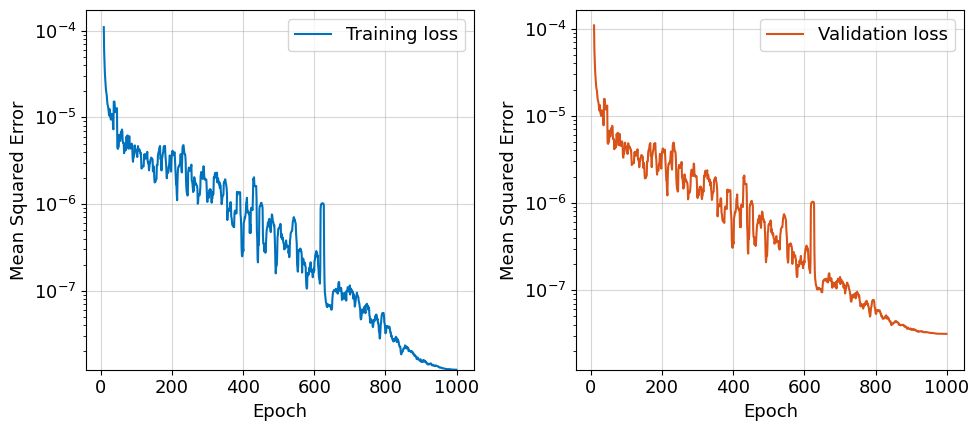

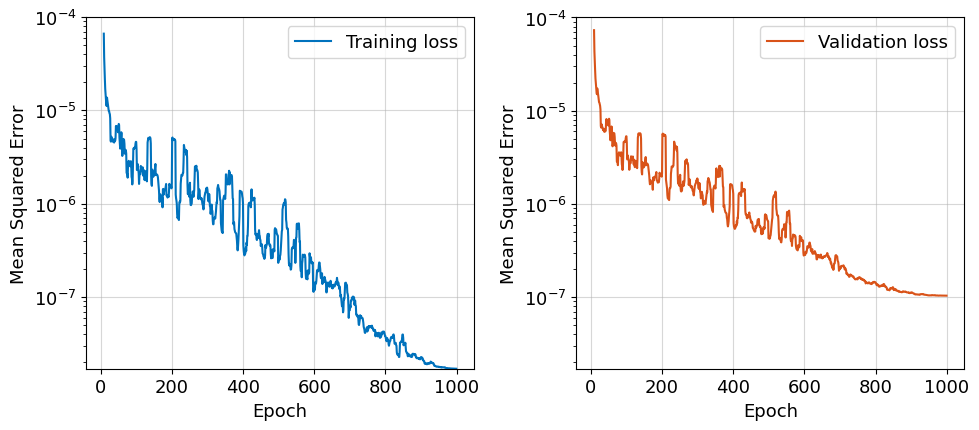

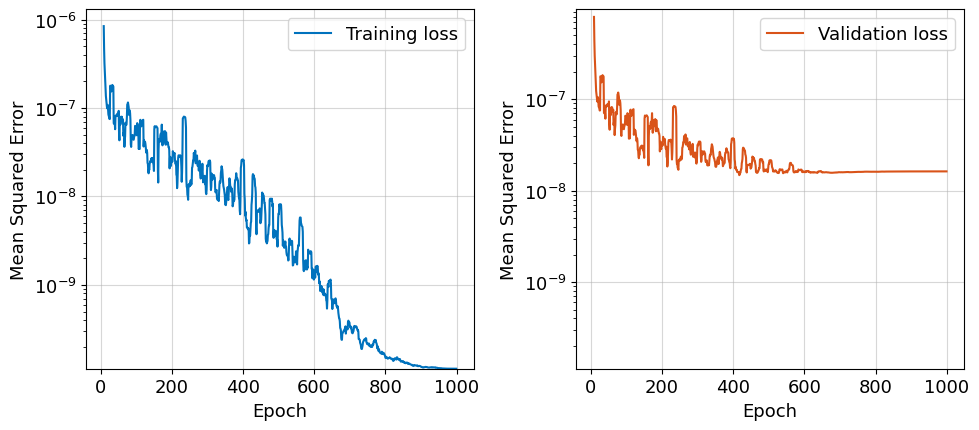

In [17]:
surrogate_labels = {
    "F": "Full",
    "ABC": "Glued",
    "C": "Mu only",
}
smoothing_window = 10

# plot the training and the validation loss for all but the true surrogate
for key, surrogate in [(k, v) for k, v in surrogates.items() if k != "True"]:
    loss_dict = surrogate.loss_dict
    save_name = f"loss_curves_{key}{figure_suffix}"
    fig, ax = plots.plot_training_validation_loss(
        loss_dict,
        label=surrogate_labels[key],
        ylim=min(np.minimum(loss_dict["training_loss"], loss_dict["validation_loss"])),
        smoothing_window=smoothing_window,
        selected_keys=[
            "training_loss",
            "validation_loss",
        ],
        save_path=figures_path,
        save_name=save_name,
        locators=False,
    )
    plt.show()

### Error histograms
Compare relative error distributions across surrogate variants.

We start by comparing the prediction of different surrogates for capital.

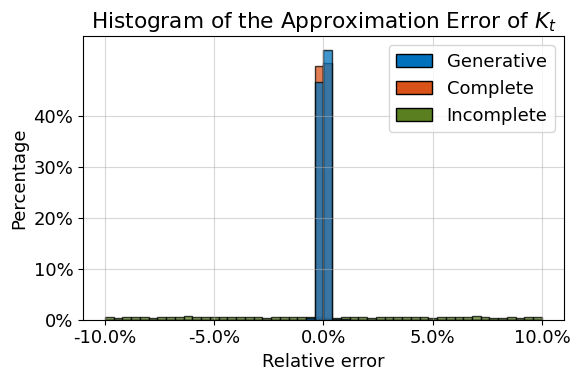

In [18]:
# Example with three surrogates
plots.plot_error_histogram_three(
    surrogate1=surrogates["C"],
    surrogate2=surrogates["F"],
    surrogate3=surrogates["ABC"],
    x_validation=surrogates["F"].data_validation["x"],
    y_validation=surrogates["F"].data_validation["y"],
    y_labels=["K", "C", "L"],
    plot_vars=["K"],
    save_name="error_histogram_three",
    save_path=figures_path,
    ncol=1,
    sub_figsize=(6, 4),
    x_range=(-0.1, 0.1),
    maxpercent=0.5,
    percentsteps=0.1,
    Latex_label=[
        r"Histogram of the Approximation Error of $K_t$",
    ],
)

We then compare the predictions of different surrogate models for consumption and labor.

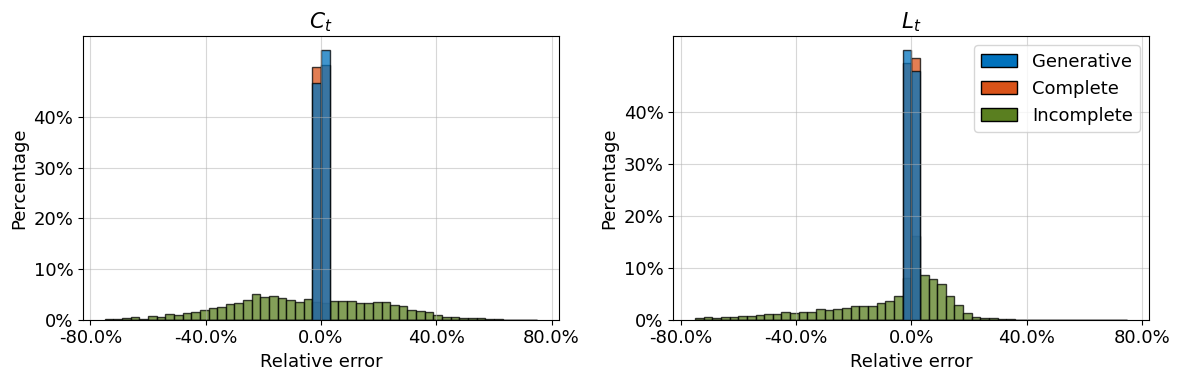

In [19]:
plots.plot_error_histogram_three(
    surrogate1=surrogates["C"],
    surrogate2=surrogates["F"],
    surrogate3=surrogates["ABC"],
    x_validation=surrogates["F"].data_validation["x"],
    y_validation=surrogates["F"].data_validation["y"],
    y_labels=["K", "C", "L"],
    plot_vars=["C", "L"],
    save_name="error_histogram_three_other_variables",
    save_path=figures_path,
    ncol=2,
    sub_figsize=(6, 4),
    x_range=(-0.75, 0.75),
    maxpercent=0.5,
    percentsteps=0.1,
    Latex_label=[r"$C_t$", r"$L_t$"],
)


Moreover, we can zoom into to better see the difference between the generative and complete surrogates.

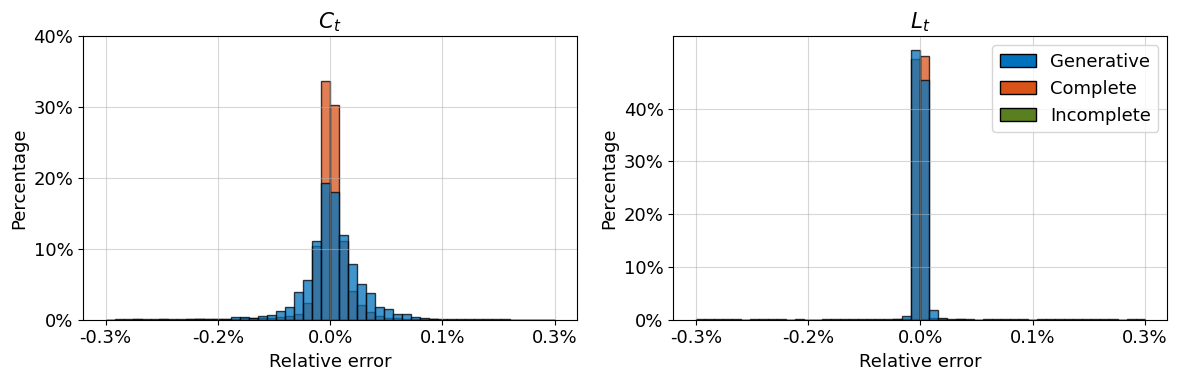

In [20]:
plots.plot_error_histogram_three(
    surrogate1=surrogates["C"],
    surrogate2=surrogates["F"],
    surrogate3=surrogates["ABC"],
    x_validation=surrogates["F"].data_validation["x"],
    y_validation=surrogates["F"].data_validation["y"],
    y_labels=["K", "C", "L"],
    plot_vars=["C", "L"],
    save_name="error_histogram_three_other_variables_zoomed",
    save_path=figures_path,
    ncol=2,
    sub_figsize=(6, 4),
    x_range=(-0.003, 0.003),
    maxpercent=0.5,
    percentsteps=0.1,
    Latex_label=[r"$C_t$", r"$L_t$"],
)

### Shock extraction and Monte Carlo setup
Extract realized shocks and generate antithetic Monte Carlo draws for Euler error evaluation.


In [21]:
# extracting the shocks from the full dataset
exo_shocks_BM = data_all["x"][:, 1:4]

# extract the shocks into a dataframe
shocks_df = pd.DataFrame(exo_shocks_BM.cpu().numpy(), columns=["A", "Z", "mu"])
rhos = torch.tensor([0.9, 0.9, 0.0], device=device, dtype=torch.float32)
log_means = torch.log(torch.tensor([par["Abar"], par["Zbar"], par["mubar"]], device=device, dtype=torch.float32))
stds = torch.tensor([0.05, 0.05, 0.05], device=device)
log_means[2] = stds[2] ** 2  # set mean of mu to 1

# fix the seed for reproducibility
torch.manual_seed(420)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(420)

# number of Monte Carlo simulations
N_monte_carlo = 5000

# simulate the shocks
eps = torch.randn(N_monte_carlo // 2, 3, device=device)

# mirror the same shocks again (antithetic)
eps = torch.cat((eps, -eps), dim=0)

## Set up shocks and states


*Note that we draw Monte Carlo shocks (with antithetic pairs) and compute Euler equation errors for static and dynamic evaluations of the surrogate policies.*


### Static Euler equation error (mean state)
Construct tensors for states/shocks and compare analytical vs. surrogate Euler errors at the mean state.


In [22]:
predict = ["Kp", "C", "L"]
states = ["K", "A", "Z", "mu"]

# transform the parameters to tensors
device = eps.device
dtype = eps.dtype
means = torch.as_tensor(data_all["x"][0, 1:4], device=device, dtype=dtype)
rhos_t = torch.as_tensor(rhos, device=device, dtype=dtype)
stds_t = torch.as_tensor(stds, device=device, dtype=dtype)

# static evaluation of the Euler Equation Error at the mean state
EEE_static = {}
EEE_analytical = {}
print("Static Euler Equation Error at the mean state:")
for name in ["F", "ABC"]:
    todays_state = data_all["x"][6, :4].to(device)
    future_exo_states = ar1_lognormal_draws(states=todays_state[1:], rhos=rhos, stds=stds, shocks=eps, log_means=log_means)  # A, Z, mu today
    EEE_analytical[name] = calculate_EEE_BM_Ana(todays_state, future_exo_states, par)
    EEE_static[name] = calculate_EEE_BM(todays_state, surrogates[name], future_exo_states, par)
    print(f"BM EEE of {name} at mean state: {EEE_static[name]:.5f}")
    print(f"Analytical EEE of {name} at mean state: {EEE_analytical[name]:.5f}")

Static Euler Equation Error at the mean state:
BM EEE of F at mean state: 0.00003
Analytical EEE of F at mean state: 0.00002
BM EEE of ABC at mean state: 0.00003
Analytical EEE of ABC at mean state: 0.00002


### Dynamic Euler equation error
Simulate the economy forward and compute Euler errors period by period.


In [23]:
N_sim = 1000  # lower number than in the paper, but for faster runtime

# simulating forward
print(f"Dynamic Euler Equation Error for {N_sim} periods:")
EEE = {}

# simulate the economy forward
for name in ["F", "ABC"]:
    # initialize the state with the mean state from the full dataset
    todays_state = data_all["x"][0, :4].to(device)

    # initialize lists to store the results
    EEE[name] = []

    # get the surrogate model
    surrogate = surrogates[name]

    # simulating the economy forward for N_sim periods
    for t in trange(N_sim - 1):
        # simulate the shocks
        shocks = torch.randn(N_monte_carlo // 2, 3, device=device)

        # mirror the same shocks again (antithetic)
        shocks = torch.cat((shocks, -shocks), dim=0)

        # draw the shocks for the next period to calculate the EEE
        exo_shocks = ar1_lognormal_draws(
            states=todays_state[1:],
            rhos=rhos,
            stds=stds,
            shocks=eps,
            log_means=log_means,
        )

        # calculate the EEE for the current period
        EEE_t = calculate_EEE_BM(todays_state, surrogates[name], exo_shocks, par)

        # store the EEE in a list
        EEE[name].append(EEE_t)

        # simulate the economy one period ahead
        next_state = simulate_BM(todays_state, surrogates[name], exo_shocks_BM[t + 1, :], device=device).squeeze()

        # update the todays_state variable
        todays_state = next_state.detach().squeeze().clone()

    # print the average EEE over the simulated periods
    print(f"Average BM EEE of {name} over {N_sim} periods: {np.mean(EEE[name]):.5f}%")

Dynamic Euler Equation Error for 1000 periods:


100%|██████████| 999/999 [00:50<00:00, 19.60it/s]


Average BM EEE of F over 1000 periods: 0.00007%


100%|██████████| 999/999 [00:47<00:00, 21.02it/s]


Average BM EEE of ABC over 1000 periods: 0.00016%


### Euler error histogram
Visualize the distribution of Euler equation errors on a log scale.


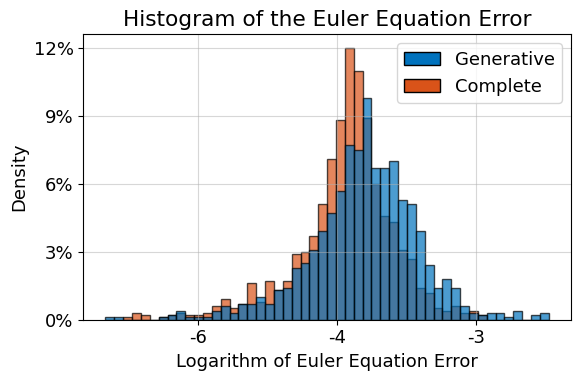

In [24]:
plots.plot_euler_error_histogram(
    EEE["F"],
    EEE["ABC"],
    save_path=figures_path,
    save_name="dynamic_euler_error_histogram",
    number_bins=50,
    num_locators_x=5,
    num_locators_y=5,
)

### Forward simulation and standardized moments
Simulate capital paths under each surrogate and report mean, std, skewness, and kurtosis.


In [25]:
Capital = {}
# simulate the economy forward
for name, data in [
    ("F", data_all["x"][:, :4].to(device)),
    ("ABC", data_all["x"][:, :4].to(device)),
    ("C", data_C["x"][:, :4].to(device)),
]:
    # initialize the state with the mean state from the full dataset
    todays_state = data[0, :4].to(device)

    # load the surrogate model
    surrogate = surrogates[name]

    # initialize lists to store the results
    Capital[name] = []

    # simulating the economy forward for N_sim periods
    for t in trange(N_sim - 1):
        # store the capital in a list
        Capital[name].append(todays_state[0].item())

        # simulate the economy one period ahead
        next_state = simulate_BM(todays_state, surrogates[name], data[t + 1, 1:4], device=device).squeeze()

        # update the todays_state variable
        todays_state = next_state.detach().squeeze().clone()


# Print standardized moments as a formatted table
moment_names = ["Mean", "Std", "Skewness", "Kurtosis"]
results = []
for name in ["F", "ABC", "C"]:
    moments = standardized_moments(Capital[name])
    results.append([name] + [f"{m:.4f}" for m in moments])

df_moments = pd.DataFrame(results, columns=["Model"] + moment_names)
print(df_moments.to_string(index=False))

100%|██████████| 999/999 [00:01<00:00, 975.60it/s] 


Model   Mean    Std Skewness Kurtosis
    F 0.2118 0.0396   0.1722  -0.1459
  ABC 0.2119 0.0396   0.1753  -0.1547
    C 0.2012 0.0014  -4.1196  63.3752
